### Connecting to the database and main tables

In [83]:
import pandas as pd

### User data

PG_URL = os.getenviron("PG_URL")
PG_PORT = os.getenviron("PG_PORT")
PG_SCHEMA = os.getenviron("PG_SCHEMA")
PG_LOGIN = os.getenviron("PG_LOGIN")
PG_PASSWORD = os.getenviron("PG_PASSWORD")

user_info = pd.read_sql(
    """SELECT * FROM public.user_data""",
    
    con="postgresql://{PG_LOGIN}:{PG_PASSWORD}"
        "{PG_URL}:{PG_PORT}/{PG_SCHEMA}"
)

user_info.head()

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads


In [84]:
### Posts and topics

posts_info = pd.read_sql(
    """SELECT * FROM public.post_text_df""",
    
    con="postgresql://{PG_LOGIN}:{PG_PASSWORD}"
        "{PG_URL}:{PG_PORT}/{PG_SCHEMA}"
)

posts_info.head()

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business


In [3]:
### Almost 77 million records, that's a lot!
### Not every operative will fit so much data
### For training models
    
count_feed_data = pd.read_sql(
    """SELECT count(*) FROM public.feed_data""",
    
    con="postgresql://{PG_LOGIN}:{PG_PASSWORD}"
        "{PG_URL}:{PG_PORT}/{PG_SCHEMA}"
)

count_feed_data.head()


,count
0,76892800


In [85]:
### Let's try to take, say, 10 million

feed_data = pd.read_sql(
    """SELECT * 
       FROM (
         SELECT
           ROW_NUMBER() OVER (PARTITION BY user_id) AS r,
           t.*
         FROM
           public.feed_data t) x
        WHERE
          x.r<=10""",
    
    con="postgresql://{PG_LOGIN}:{PG_PASSWORD}"
        "{PG_URL}:{PG_PORT}/{PG_SCHEMA}"
)

feed_data.head()

,r,timestamp,user_id,post_id,action,target
0,1,2021-12-24 14:07:39,200,1392,view,0
1,2,2021-12-24 14:09:14,200,4183,view,0
2,3,2021-12-24 14:10:30,200,3930,view,0
3,4,2021-12-24 14:11:10,200,2979,view,0
4,5,2021-12-24 14:11:25,200,4093,view,0


In [86]:
feed_data.shape

(1632050, 6)

In [87]:
feed_data = feed_data.drop(['r'], axis = 1)

In [88]:
feed_data

,timestamp,user_id,post_id,action,target
0,2021-12-24 14:07:39,200,1392,view,0
1,2021-12-24 14:09:14,200,4183,view,0
2,2021-12-24 14:10:30,200,3930,view,0
3,2021-12-24 14:11:10,200,2979,view,0
4,2021-12-24 14:11:25,200,4093,view,0
...,...,...,...,...,...
1632045,2021-12-21 09:17:04,168552,7158,view,0
1632046,2021-12-21 09:17:52,168552,827,view,0
1632047,2021-12-21 09:20:23,168552,5141,view,0
1632048,2021-12-21 09:23:17,168552,2195,view,0


### Working with data and features for the content model

In [89]:
### How is the target column constructed?

feed_data[feed_data.action!='view']

,timestamp,user_id,post_id,action,target
24,2021-10-01 16:09:14,202,1223,like,0
29,2021-10-01 16:13:53,202,1299,like,0
34,2021-12-19 11:14:48,203,5883,like,0
36,2021-12-19 11:15:13,203,5379,like,0
39,2021-12-19 11:18:00,203,5289,like,0
...,...,...,...,...,...
1631974,2021-10-05 18:12:23,168545,1190,like,0
1631984,2021-12-22 14:09:40,168546,4093,like,0
1631995,2021-10-05 07:47:20,168547,226,like,0
1632020,2021-11-04 13:24:46,168550,6961,like,0


In [90]:
feed_data['action'].unique()

array(['view', 'like'], dtype=object)

In [91]:
### Let's clear the data from action != view

feed_data = feed_data[feed_data.action=='view']

feed_data.head()

,timestamp,user_id,post_id,action,target
0,2021-12-24 14:07:39,200,1392,view,0
1,2021-12-24 14:09:14,200,4183,view,0
2,2021-12-24 14:10:30,200,3930,view,0
3,2021-12-24 14:11:10,200,2979,view,0
4,2021-12-24 14:11:25,200,4093,view,0


Let's learn how to predict, based on the selected date timestamp and for any pair (user_id, post_id), whether a like will happen or not.
It would be nice to have a model that can predict probabilities

In [92]:
### It is necessary to select by user_id
### Fixed set of features
### In general, the original dataset will do

user_info

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads
...,...,...,...,...,...,...,...,...
163200,168548,0,36,Russia,Kaliningrad,4,Android,organic
163201,168549,0,18,Russia,Tula,2,Android,organic
163202,168550,1,41,Russia,Yekaterinburg,4,Android,organic
163203,168551,0,38,Russia,Moscow,3,iOS,organic


In [93]:
### Let's come up with some embedding for texts

posts_info

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business
...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie
7019,7316,I give this movie 2 stars purely because of it...,movie
7020,7317,I cant believe this film was allowed to be mad...,movie
7021,7318,The version I saw of this film was the Blockbu...,movie


In [94]:
import re
import string

from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer

wnl = WordNetLemmatizer()

def preprocessing(line, token=wnl):
    line = line.lower()
    line = re.sub(r"[{}]".format(string.punctuation), " ", line)
    line = line.replace('\n\n', ' ').replace('\n', ' ')
    line = ' '.join([token.lemmatize(x) for x in line.split(' ')])
    return line


tfidf = TfidfVectorizer(
    stop_words='english',
    preprocessor=preprocessing
)

In [95]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/anastasia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [96]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/anastasia/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [97]:
tfidf_data = (
    tfidf
    .fit_transform(posts_info['text'])
    .toarray()
)

tfidf_data

/Users/anastasia/karpov_topic2/lesson22/venv/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'wa'] not in stop_words.
  warnings.warn(


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.13273932, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.05061394, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [98]:
tfidf_data = pd.DataFrame(
    tfidf_data,
    index=posts_info.post_id,
    columns=tfidf.get_feature_names_out()
)

tfidf_data

,00,000,0001,000bn,000m,000s,000th,001,001and,001st,...,𝓫𝓮,𝓫𝓮𝓽𝓽𝓮𝓻,𝓬𝓸𝓾𝓻𝓽𝓼,𝓱𝓮𝓪𝓻𝓲𝓷𝓰,𝓶𝓪𝔂,𝓹𝓱𝔂𝓼𝓲𝓬𝓪𝓵,𝓼𝓸𝓸𝓷𝓮𝓻,𝓼𝓾𝓫𝓸𝓻𝓭𝓲𝓷𝓪𝓽𝓮,𝓽𝓱𝓮,𝓽𝓸
post_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.132739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.050614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7315,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7316,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7317,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [99]:
### We generate features based on TfIdf

posts_info['TotalTfIdf'] = tfidf_data.sum(axis=1).reset_index()[0]
posts_info['MaxTfIdf'] = tfidf_data.max(axis=1).reset_index()[0]
posts_info['MeanTfIdf'] = tfidf_data.mean(axis=1).reset_index()[0]

posts_info.head()

,post_id,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf
0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.748129,0.495805,0.000190
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.878472,0.308003,0.000258
2,3,Asian quake hits European shares\n\nShares in ...,business,12.675530,0.261799,0.000276
3,4,India power shares jump on debut\n\nShares in ...,business,6.622786,0.537713,0.000144
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,6.352096,0.420251,0.000138


In [100]:
[f"DistanceTo{ith}thCluster" for ith in range(1, 16)]

['DistanceTo1thCluster',
 'DistanceTo2thCluster',
 'DistanceTo3thCluster',
 'DistanceTo4thCluster',
 'DistanceTo5thCluster',
 'DistanceTo6thCluster',
 'DistanceTo7thCluster',
 'DistanceTo8thCluster',
 'DistanceTo9thCluster',
 'DistanceTo10thCluster',
 'DistanceTo11thCluster',
 'DistanceTo12thCluster',
 'DistanceTo13thCluster',
 'DistanceTo14thCluster',
 'DistanceTo15thCluster']

In [101]:
### Trying to cluster texts

from sklearn.decomposition import PCA

centered = tfidf_data - tfidf_data.mean()

pca = PCA(n_components=20)
pca_decomp = pca.fit_transform(centered)

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15, random_state=0).fit(pca_decomp)

posts_info['TextCluster'] = kmeans.labels_

dists_columns = ['DistanceTo1thCluster',
                 'DistanceTo2thCluster',
                 'DistanceTo3thCluster',
                 'DistanceTo4thCluster',
                 'DistanceTo5thCluster',
                 'DistanceTo6thCluster',
                 'DistanceTo7thCluster',
                 'DistanceTo8thCluster',
                 'DistanceTo9thCluster',
                 'DistanceTo10thCluster',
                 'DistanceTo11thCluster',
                 'DistanceTo12thCluster',
                 'DistanceTo13thCluster',
                 'DistanceTo14thCluster',
                 'DistanceTo15thCluster']

dists_df = pd.DataFrame(
    data=kmeans.transform(pca_decomp),
    columns=dists_columns
)

dists_df.head()

,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,DistanceTo5thCluster,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,0.438540,0.438105,0.500382,0.442001,0.385447,0.440190,0.500271,0.579643,0.498910,0.131952,0.527600,0.428913,0.477557,0.463885,0.544381
1,0.285123,0.294040,0.375958,0.280631,0.195296,0.293888,0.424798,0.344230,0.373971,0.265666,0.414332,0.156458,0.342592,0.329941,0.444711
2,0.328993,0.315742,0.390130,0.322575,0.211776,0.316546,0.431768,0.538968,0.397485,0.145986,0.435794,0.333673,0.363445,0.357632,0.479200
3,0.272032,0.257438,0.351713,0.278173,0.124958,0.263748,0.408675,0.496258,0.321818,0.240423,0.387388,0.261268,0.320496,0.299268,0.440729
4,0.234870,0.163340,0.296156,0.215690,0.067297,0.180760,0.351741,0.461784,0.297769,0.303525,0.345374,0.219389,0.260372,0.234140,0.400462


In [102]:
posts_info = pd.concat((posts_info,dists_df), axis=1)

posts_info.head()

,post_id,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,...,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.748129,0.495805,0.000190,9,0.438540,0.438105,0.500382,...,0.440190,0.500271,0.579643,0.498910,0.131952,0.527600,0.428913,0.477557,0.463885,0.544381
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.878472,0.308003,0.000258,11,0.285123,0.294040,0.375958,...,0.293888,0.424798,0.344230,0.373971,0.265666,0.414332,0.156458,0.342592,0.329941,0.444711
2,3,Asian quake hits European shares\n\nShares in ...,business,12.675530,0.261799,0.000276,9,0.328993,0.315742,0.390130,...,0.316546,0.431768,0.538968,0.397485,0.145986,0.435794,0.333673,0.363445,0.357632,0.479200
3,4,India power shares jump on debut\n\nShares in ...,business,6.622786,0.537713,0.000144,4,0.272032,0.257438,0.351713,...,0.263748,0.408675,0.496258,0.321818,0.240423,0.387388,0.261268,0.320496,0.299268,0.440729
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,6.352096,0.420251,0.000138,4,0.234870,0.163340,0.296156,...,0.180760,0.351741,0.461784,0.297769,0.303525,0.345374,0.219389,0.260372,0.234140,0.400462


In [103]:
### Let's reproduce the dataframe with all the new features

df = pd.merge(feed_data,
              posts_info,
              on='post_id',
              how='left')

df.head()

,timestamp,user_id,post_id,action,target,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,...,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,2021-12-24 14:07:39,200,1392,view,0,Moya emotional at Davis Cup win\n\nCarlos Moya...,sport,9.351419,0.363266,0.000203,...,0.297465,0.318381,0.528843,0.437649,0.423574,0.459708,0.357255,0.351269,0.379202,0.448785
1,2021-12-24 14:09:14,200,4183,view,0,#Politicians should #stop #sleeping in their #...,covid,3.010069,0.532328,0.000065,...,0.194558,0.367343,0.489439,0.215800,0.343117,0.325837,0.265794,0.270454,0.067957,0.404515
2,2021-12-24 14:10:30,200,3930,view,0,@realDonaldTrump You said Joe Biden is politic...,covid,3.132859,0.464439,0.000068,...,0.271021,0.413804,0.517956,0.292304,0.388896,0.324304,0.317458,0.330353,0.088488,0.449406
3,2021-12-24 14:11:10,200,2979,view,0,"On RTE radio 1, the #marian show with @RadioBr...",covid,3.283256,0.364039,0.000071,...,0.185609,0.365777,0.495167,0.255289,0.356283,0.301589,0.278639,0.274702,0.132691,0.414813
4,2021-12-24 14:11:25,200,4093,view,0,Only on this ridiculous platform can you post ...,covid,3.083011,0.447672,0.000067,...,0.178493,0.373174,0.487762,0.263016,0.357521,0.282923,0.272738,0.263228,0.141238,0.412904


In [104]:
df = pd.merge(df,
              user_info,
              on='user_id',
              how='left')

df.head()

,timestamp,user_id,post_id,action,target,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,...,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster,gender,age,country,city,exp_group,os,source
0,2021-12-24 14:07:39,200,1392,view,0,Moya emotional at Davis Cup win\n\nCarlos Moya...,sport,9.351419,0.363266,0.000203,...,0.351269,0.379202,0.448785,1,34,Russia,Degtyarsk,3,Android,ads
1,2021-12-24 14:09:14,200,4183,view,0,#Politicians should #stop #sleeping in their #...,covid,3.010069,0.532328,0.000065,...,0.270454,0.067957,0.404515,1,34,Russia,Degtyarsk,3,Android,ads
2,2021-12-24 14:10:30,200,3930,view,0,@realDonaldTrump You said Joe Biden is politic...,covid,3.132859,0.464439,0.000068,...,0.330353,0.088488,0.449406,1,34,Russia,Degtyarsk,3,Android,ads
3,2021-12-24 14:11:10,200,2979,view,0,"On RTE radio 1, the #marian show with @RadioBr...",covid,3.283256,0.364039,0.000071,...,0.274702,0.132691,0.414813,1,34,Russia,Degtyarsk,3,Android,ads
4,2021-12-24 14:11:25,200,4093,view,0,Only on this ridiculous platform can you post ...,covid,3.083011,0.447672,0.000067,...,0.263228,0.141238,0.412904,1,34,Russia,Degtyarsk,3,Android,ads


In [105]:
### we will generate signs from timestamp (it may depend on viewing time tendency of users to like or ignore posts)

df['hour'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.hour)
df['month'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.month)

df.head()

,timestamp,user_id,post_id,action,target,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,...,DistanceTo15thCluster,gender,age,country,city,exp_group,os,source,hour,month
0,2021-12-24 14:07:39,200,1392,view,0,Moya emotional at Davis Cup win\n\nCarlos Moya...,sport,9.351419,0.363266,0.000203,...,0.448785,1,34,Russia,Degtyarsk,3,Android,ads,14,12
1,2021-12-24 14:09:14,200,4183,view,0,#Politicians should #stop #sleeping in their #...,covid,3.010069,0.532328,0.000065,...,0.404515,1,34,Russia,Degtyarsk,3,Android,ads,14,12
2,2021-12-24 14:10:30,200,3930,view,0,@realDonaldTrump You said Joe Biden is politic...,covid,3.132859,0.464439,0.000068,...,0.449406,1,34,Russia,Degtyarsk,3,Android,ads,14,12
3,2021-12-24 14:11:10,200,2979,view,0,"On RTE radio 1, the #marian show with @RadioBr...",covid,3.283256,0.364039,0.000071,...,0.414813,1,34,Russia,Degtyarsk,3,Android,ads,14,12
4,2021-12-24 14:11:25,200,4093,view,0,Only on this ridiculous platform can you post ...,covid,3.083011,0.447672,0.000067,...,0.412904,1,34,Russia,Degtyarsk,3,Android,ads,14,12


In [106]:
### Let's remove all unnecessary columns

df = df.drop([
#    'timestamp',  ### Let's leave the timestamp for now
    'action',
    'text',
],
    axis=1)

df = df.set_index(['user_id', 'post_id'])

df.head(50)



timestamp  target          topic  TotalTfIdf  \
user_id post_id                                                          
200     1392    2021-12-24 14:07:39       0          sport    9.351419   
        4183    2021-12-24 14:09:14       0          covid    3.010069   
        3930    2021-12-24 14:10:30       0          covid    3.132859   
        2979    2021-12-24 14:11:10       0          covid    3.283256   
        4093    2021-12-24 14:11:25       0          covid    3.083011   
        1304    2021-12-24 14:13:13       0       politics   10.820998   
        6087    2021-12-29 14:50:01       0          movie    8.662011   
        3895    2021-12-29 14:50:37       0          covid    3.294216   
        4423    2021-12-29 14:52:07       0          movie    6.345626   
        4200    2021-12-29 14:55:04       1          covid    3.405408   
201     2915    2021-10-18 17:06:06       0          covid    3.132384   
        1033    2021-10-04 09:44:05       0       politics    9.372594   
        6917    2021-10-04 09:45:34       0          movie   11.334275   
        3991    2021-10-04 09:45:50       0          covid    2.664540   
        4240    2021-10-04 09:46:35       0          movie    6.049611   
        3270    2021-10-04 09:48:51       0          covid    2.966079   
        2717    2021-10-04 09:51:23       0          covid    2.953005   
        443     2021-10-04 09:53:49       0       business    8.258992   
        6445    2021-10-04 09:56:39       0          movie   11.472287   
        649     2021-10-04 09:58:03       1  entertainment    8.977608   
202     1262    2021-10-24 21:25:01       1       politics    8.271786   
        5970    2021-10-01 16:03:41       0          movie   10.408582   
        6803    2021-10-01 16:04:34       0          movie    6.563542   
        1223    2021-10-01 16:06:21       1       politics    9.334661   
        1300    2021-10-01 16:09:16       0       politics    8.625053   
        1219    2021-10-01 16:10:45       0       politics   10.143342   
        3425    2021-10-01 16:10:55       0          covid    3.204676   
        1299    2021-10-01 16:12:54       1       politics   10.521051   
203     7315    2021-12-19 11:09:16       0          movie    6.703302   
        6309    2021-12-19 11:10:55       0          movie    5.532010   
        967     2021-12-19 11:11:08       0       politics    7.696906   
        5883    2021-12-19 11:12:06       1          movie    6.592083   
        5379    2021-12-19 11:14:50       1          movie   12.645631   
        6935    2021-12-19 11:15:15       0          movie    6.328142   
        5289    2021-12-19 11:17:24       1          movie    9.142711   
204     1320    2021-11-17 22:07:47       0       politics   10.485196   
        5387    2021-11-17 21:37:44       0          movie    7.249926   
        3712    2021-11-17 21:39:02       0          covid    3.511469   
        415     2021-11-17 21:41:43       0       business   10.098147   
        5373    2021-11-17 21:42:02       1          movie    7.039367   
        4485    2021-11-17 21:44:50       0          movie    5.926413   
        2439    2021-11-17 21:46:52       0          covid    3.298286   
        5607    2021-11-17 21:48:58       0          movie    6.236765   
        1946    2021-11-17 21:49:55       0           tech    8.999823   
205     6706    2021-11-04 15:25:08       1          movie    6.050302   
        1870    2021-12-27 07:00:55       0          sport    7.077789   
        3433    2021-12-27 06:58:25       0          covid    3.055468   
        1746    2021-12-27 06:57:05       0          sport    7.111764   
        1684    2021-12-27 06:55:48       0          sport    9.712337   
        1852    2021-12-27 06:55:03       0          sport   11.154460   

                 MaxTfIdf  MeanTfIdf  TextCluster  DistanceTo1thCluster  \
user_id post_id                                                           
200     1392     0.363266  

### It's time to train the models!

In [107]:
### let's start with the decision tree
### How to validate? How can we divide it into train and test? I suggest by time, since the data has
### Temporary structure! We want to correctly assess the probabilities for future recommendations

max(df.timestamp), min(df.timestamp)

(Timestamp('2021-12-29 23:51:06'), Timestamp('2021-10-01 06:01:40'))

In [108]:
### Let's take 2021-12-15 as the cutoff

df_train = df[df.timestamp < '2021-12-15']
df_test = df[df.timestamp >= '2021-12-15']

df_train = df_train.drop('timestamp', axis=1)
df_test = df_test.drop('timestamp', axis=1)

X_train = df_train.drop('target', axis=1)
X_test = df_test.drop('target', axis=1)

y_train = df_train['target']
y_test = df_test['target']

y_train.shape, y_test.shape

((1187713,), (276141,))

In [109]:
X_train

topic  TotalTfIdf  MaxTfIdf  MeanTfIdf  TextCluster  \
user_id post_id                                                           
201     2915        covid    3.132384  0.367836   0.000068            1   
        1033     politics    9.372594  0.402888   0.000204           11   
        6917        movie   11.334275  0.569247   0.000246            5   
        3991        covid    2.664540  0.634723   0.000058           13   
        4240        movie    6.049611  0.334944   0.000132            5   
...                   ...         ...       ...        ...          ...   
168551  1542        sport    8.843492  0.492478   0.000192            3   
        283      business    7.176359  0.546841   0.000156            4   
        3708        covid    2.691494  0.499755   0.000059           13   
        6962        movie    7.063463  0.383749   0.000154            5   
        5285        movie    7.157651  0.235437   0.000156            2   

                 DistanceTo1thCluster  DistanceTo2thCluster  \
user_id post_id                                               
201     2915                 0.290077              0.050276   
        1033                 0.376100              0.364495   
        6917                 0.297006              0.237167   
        3991                 0.321083              0.093686   
        4240                 0.282308              0.186017   
...                               ...                   ...   
168551  1542                 0.398961              0.349663   
        283                  0.277763              0.222464   
        3708                 0.330378              0.137650   
        6962                 0.302604              0.205005   
        5285                 0.330621              0.255932   

                 DistanceTo3thCluster  DistanceTo4thCluster  \
user_id post_id                                               
201     2915                 0.278562              0.229776   
        1033                 0.425516              0.368213   
        6917                 0.254123              0.228023   
        3991                 0.324005              0.261377   
        4240                 0.277416              0.245393   
...                               ...                   ...   
168551  1542                 0.396467              0.189172   
        283                  0.328897              0.257415   
        3708                 0.344859              0.283376   
        6962                 0.147019              0.229722   
        5285                 0.112765              0.273674   

                 DistanceTo5thCluster  ...  DistanceTo15thCluster  gender  \
user_id post_id                        ...                                  
201     2915                 0.195836  ...               0.408120       0   
        1033                 0.333654  ...               0.501312       0   
        6917                 0.230345  ...               0.394010       0   
        3991                 0.237937  ...               0.427661       0   
        4240                 0.207715  ...               0.408321       0   
...                               ...  ...                    ...     ...   
168551  1542                 0.331947  ...               0.425215       0   
        283                  0.114707  ...               0.425755       0   
        3708                 0.258762  ...               0.438082       0   
        6962                 0.219374  ...               0.404949       0   
        5285                 0.258054  ...               0.421420       0   

                 age  country    city  exp_group       os   source  hour  \
user_id post_id                                                            
201     2915      37   Russia  Abakan          0  Android      ads    17   
        1033      37   Russia  Abakan          0  Android      ads     9   
        6917      37   Russia  Abakan          0  Android      ads     9   
        3991      37  

In [110]:
X_test

topic  TotalTfIdf  MaxTfIdf  MeanTfIdf  TextCluster  \
user_id post_id                                                                
200     1392             sport    9.351419  0.363266   0.000203            3   
        4183             covid    3.010069  0.532328   0.000065           13   
        3930             covid    3.132859  0.464439   0.000068           13   
        2979             covid    3.283256  0.364039   0.000071            1   
        4093             covid    3.083011  0.447672   0.000067            1   
...                        ...         ...       ...        ...          ...   
168552  7158             movie    5.922264  0.518646   0.000129            2   
        827      entertainment    7.300086  0.634667   0.000159            4   
        5141             movie    3.917527  0.370002   0.000085            5   
        2195              tech    8.461666  0.419507   0.000184            0   
        3351             covid    3.862917  0.343626   0.000084            8   

                 DistanceTo1thCluster  DistanceTo2thCluster  \
user_id post_id                                               
200     1392                 0.375688              0.352311   
        4183                 0.294616              0.114973   
        3930                 0.340748              0.159450   
        2979                 0.295293              0.038926   
        4093                 0.264311              0.061979   
...                               ...                   ...   
168552  7158                 0.387936              0.311319   
        827                  0.243451              0.178764   
        5141                 0.310073              0.199398   
        2195                 0.221489              0.322111   
        3351                 0.380631              0.243723   

                 DistanceTo3thCluster  DistanceTo4thCluster  \
user_id post_id                                               
200     1392                 0.365398              0.164819   
        4183                 0.304486              0.256360   
        3930                 0.357340              0.299171   
        2979                 0.304858              0.247780   
        4093                 0.294095              0.245654   
...                               ...                   ...   
168552  7158                 0.087501              0.342370   
        827                  0.287459              0.197121   
        5141                 0.162830              0.241080   
        2195                 0.393069              0.346558   
        3351                 0.386535              0.339673   

                 DistanceTo5thCluster  ...  DistanceTo15thCluster  gender  \
user_id post_id                        ...                                  
200     1392                 0.317174  ...               0.448785       1   
        4183                 0.208593  ...               0.404515       1   
        3930                 0.270601  ...               0.449406       1   
        2979                 0.203408  ...               0.414813       1   
        4093                 0.207978  ...               0.412904       1   
...                               ...  ...                    ...     ...   
168552  7158                 0.335633  ...               0.494583       1   
        827                  0.116048  ...               0.384309       1   
        5141                 0.223971  ...               0.416187       1   
        2195                 0.300741  ...               0.485723       1   
        3351                 0.307820  ...               0.477706       1   

                 age  country         city  exp_group       os   source  hour  \
user_id post_id                                                                 
200     1392      34   Russia    Degtyarsk          3  Android      ads    14   
        4183      34   Russia    Degtyarsk          3  Android      ads    14   
        3930      

In [111]:
y_train.unique()

array([0, 1])

In [112]:
y_test.unique()

array([0, 1])

In [113]:
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from category_encoders.one_hot import OneHotEncoder

object_cols = [
    'topic', 'TextCluster', 'gender', 'country',
    'city', 'exp_group', 'hour', 'month',
    'os', 'source'
]

cols_for_ohe = [x for x in object_cols if X_train[x].nunique() < 5]
cols_for_mte = [x for x in object_cols if X_train[x].nunique() >= 5]

### Let's save the indexes of these columns

cols_for_ohe_idx = [list(X_train.columns).index(col) for col in cols_for_ohe]
cols_for_mte_idx = [list(X_train.columns).index(col) for col in cols_for_mte]

t = [
    ('OneHotEncoder', OneHotEncoder(), cols_for_ohe_idx),
    ('MeanTargetEncoder', TargetEncoder(), cols_for_mte_idx)
]

col_transform = ColumnTransformer(transformers=t)

from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

pipe_dt = Pipeline([("column_transformer",
                     col_transform),
                     
                    ("decision_tree", 
                     DecisionTreeClassifier())])

pipe_dt.fit(X_train, y_train)

/Users/anastasia/karpov_topic2/lesson22/venv/lib/python3.9/site-packages/category_encoders/target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Users/anastasia/karpov_topic2/lesson22/venv/lib/python3.9/site-packages/category_encoders/target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
/Users/anastasia/karpov_topic2/lesson22/venv/lib/python3.9/site-packages/category_encoders/target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  [20, 28, 25, 26]),
                                                 ('MeanTargetEncoder',
                                                  TargetEncoder(),
                                                  [0, 4, 22, 23, 24, 27])])),
                ('decision_tree', DecisionTreeClassifier())])

In [114]:
### Let's measure the quality of work of such a model. Let's take ROC-AUC

from sklearn.metrics import roc_auc_score

print(f"Качество на трейне: {roc_auc_score(y_train, pipe_dt.predict_proba(X_train)[:, 1])}")
print(f"Качество на тесте: {roc_auc_score(y_test, pipe_dt.predict_proba(X_test)[:, 1])}")

Качество на трейне: 0.9753550755146563
Качество на тесте: 0.5236474989974661


In [115]:
### Now let's train catboost!

from catboost import CatBoostClassifier

catboost = CatBoostClassifier(iterations=100,
                              learning_rate=1,
                              depth=2)


catboost.fit(X_train, y_train, object_cols)

0:	learn: 0.3632707	total: 1.15s	remaining: 1m 53s
1:	learn: 0.3590046	total: 2.37s	remaining: 1m 55s
2:	learn: 0.3544139	total: 3.03s	remaining: 1m 37s
3:	learn: 0.3532090	total: 3.52s	remaining: 1m 24s
4:	learn: 0.3524450	total: 3.96s	remaining: 1m 15s
5:	learn: 0.3520071	total: 4.38s	remaining: 1m 8s
6:	learn: 0.3518715	total: 4.76s	remaining: 1m 3s
7:	learn: 0.3517826	total: 5.15s	remaining: 59.2s
8:	learn: 0.3516444	total: 5.51s	remaining: 55.7s
9:	learn: 0.3515840	total: 5.86s	remaining: 52.7s
10:	learn: 0.3515179	total: 6.21s	remaining: 50.3s
11:	learn: 0.3514770	total: 6.57s	remaining: 48.2s
12:	learn: 0.3510830	total: 6.93s	remaining: 46.4s
13:	learn: 0.3505104	total: 7.29s	remaining: 44.8s
14:	learn: 0.3504521	total: 7.65s	remaining: 43.4s
15:	learn: 0.3503741	total: 8.01s	remaining: 42s
16:	learn: 0.3503477	total: 8.37s	remaining: 40.9s
17:	learn: 0.3503320	total: 8.74s	remaining: 39.8s
18:	learn: 0.3501419	total: 9.11s	remaining: 38.8s
19:	learn: 0.3498854	total: 9.48s	rema

In [116]:
### Let's measure the quality of work of such a model. Let's take ROC-AUC

print(f"Качество на трейне: {roc_auc_score(y_train, catboost.predict_proba(X_train)[:, 1])}")
print(f"Качество на тесте: {roc_auc_score(y_test, catboost.predict_proba(X_test)[:, 1])}")

Качество на трейне: 0.6668868863834696
Качество на тесте: 0.6632056332837291


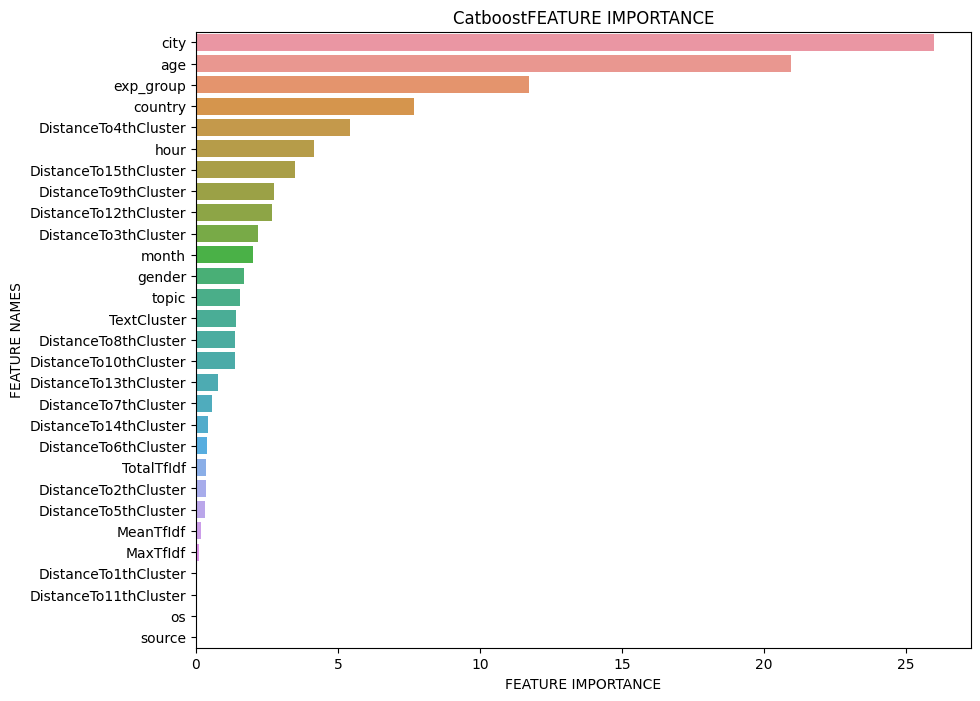

In [117]:
### Out of curiosity, let's look at feature_importance

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
plot_feature_importance(catboost.feature_importances_,X_train.columns,'Catboost')

In [118]:
### Save the model

catboost.save_model(
    'catboost_model',
    format="cbm"                  
)

### Let's put into the database the features necessary for the functionality of our model

In [119]:
df.to_sql(    
   "anastasia_korotkova_features",                    
    con="postgresql://{PG_LOGIN}:{PG_PASSWORD}"
        "{PG_URL}:{PG_PORT}/{PG_SCHEMA}",                      
    schema="public",                   
    if_exists='replace'            
   )                               
                

854

In [97]:
posts_info.to_sql(    
   "anastasia_korotkova_features",                    
    con="postgresql://{PG_LOGIN}:{PG_PASSWORD}"
        "{PG_URL}:{PG_PORT}/{PG_SCHEMA}",                      
    schema="public",                   
    if_exists='replace'            
   )                                                               

23

In [120]:
### Is everything okay?

test_ = pd.read_sql(
    """SELECT * FROM public.anastasia_korotkova_features""",
    
    con="postgresql://{PG_LOGIN}:{PG_PASSWORD}"
        "{PG_URL}:{PG_PORT}/{PG_SCHEMA}"
)

test_

,user_id,post_id,timestamp,target,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,TextCluster,DistanceTo1thCluster,...,DistanceTo15thCluster,gender,age,country,city,exp_group,os,source,hour,month
0,200,1392,2021-12-24 14:07:39,0,sport,9.351419,0.363266,0.000203,3,0.375688,...,0.448785,1,34,Russia,Degtyarsk,3,Android,ads,14,12
1,200,4183,2021-12-24 14:09:14,0,covid,3.010069,0.532328,0.000065,13,0.294616,...,0.404515,1,34,Russia,Degtyarsk,3,Android,ads,14,12
2,200,3930,2021-12-24 14:10:30,0,covid,3.132859,0.464439,0.000068,13,0.340748,...,0.449406,1,34,Russia,Degtyarsk,3,Android,ads,14,12
3,200,2979,2021-12-24 14:11:10,0,covid,3.283256,0.364039,0.000071,1,0.295293,...,0.414813,1,34,Russia,Degtyarsk,3,Android,ads,14,12
4,200,4093,2021-12-24 14:11:25,0,covid,3.083011,0.447672,0.000067,1,0.264311,...,0.412904,1,34,Russia,Degtyarsk,3,Android,ads,14,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463849,168552,7158,2021-12-21 09:17:04,0,movie,5.922264,0.518646,0.000129,2,0.387936,...,0.494583,1,16,Russia,Ivanteyevka,4,Android,organic,9,12
1463850,168552,827,2021-12-21 09:17:52,0,entertainment,7.300086,0.634667,0.000159,4,0.243451,...,0.384309,1,16,Russia,Ivanteyevka,4,Android,organic,9,12
1463851,168552,5141,2021-12-21 09:20:23,0,movie,3.917527,0.370002,0.000085,5,0.310073,...,0.416187,1,16,Russia,Ivanteyevka,4,Android,organic,9,12
1463852,168552,2195,2021-12-21 09:23:17,0,tech,8.461666,0.419507,0.000184,0,0.221489,...,0.485723,1,16,Russia,Ivanteyevka,4,Android,organic,9,12
